## Eutopia Intern Task

In [49]:
# import useful packages

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pickle
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from collections import Counter
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Load the data

In [50]:
# import the data

filename = '../dataset.pickle'
infile = open(filename,'rb')
data = pickle.load(infile)
infile.close()

In [51]:
# use the ID of the company as index to remove one column

data.index = data.crunchbase_ID
data = data.drop('crunchbase_ID', axis=1)

In [52]:
# split into data and labels

y = data.AI
x = data.copy().drop('AI', axis=1)

In [53]:
# inspect null values

x.isnull().sum()

home_text           0
aboutus_text     2682
overview_text    4828
whatwedo_text    4844
company_text     4417
whoweare_text    4811
dtype: int64

In [54]:
# Group all the text in one field: assume all the fields give the same information

x.fillna('', inplace = True) # replace nan to concatenate columns
x['alltext'] = x.home_text + x.aboutus_text + x.overview_text + x.whatwedo_text + x.company_text +x.whoweare_text
x = pd.DataFrame(x.alltext) 

In [55]:
# Text preprocessing

x.alltext = x.alltext.str.lower() # Lowercase
x.alltext = x.alltext.str.replace('\d+', '') # Remove numbers
x.alltext = x.alltext.str.replace('[^\w\s]','') # Remove punctuation
x.alltext = x.alltext.str.strip()   # Remove whitespaces
x.alltext = x.apply(lambda row: nltk.word_tokenize(row['alltext']), axis=1) # tokenize words

stop_words = set(stopwords.words('english')) # Import stop words to remove
x.alltext = x.alltext.apply(lambda x:[item for item in x if item not in stop_words])  # Remove stop words

x

,alltext
crunchbase_ID,
1916,"[skip, main, content, products, gpu, accelerat..."
1917,"[ais, research, company, careers, get, touch, ..."
1918,"[toggle, navigation, product, projects, compan..."
1919,"[brainpeek, solutions, create, seamless, onlin..."
1920,"[tool, languages, services, extract, product, ..."
...,...
2735,"[username, email, l, senord, remember, norsk, ..."
5944,"[solutions, solution, distributors, covered, r..."
5251,"[browse, products, variety, cases, pasta, mac,..."


In [56]:
# split into training set and test set

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 1)

## Text feature Extraction

In [57]:
# function to extract the vocabulary

def extract_vocabulary(dataseries, vocab_size):
    unk_token = '<UNK>'    # Out-of-vocabulary words
    special_tokens = [unk_token]
    counter = Counter(word for text in dataseries.iteritems() for word in text[1])  # Count word appeareance
    most_common_counts = counter.most_common(vocab_size-1)   # Select the vocab_size -1 most common words, the last is UNK
    most_frequent_words = [word for (word, count) in most_common_counts]
    idx2token = special_tokens + most_frequent_words
    token2idx = {token: token_id for token_id, token in enumerate(idx2token)}
    return unk_token, token2idx, most_common_counts

In [58]:
# extract the vocabulary

vocab_size = 3000 
unk_token, token2idx, most_common_counts = extract_vocabulary(x_train.alltext, vocab_size=vocab_size)  # Extract vocabulary only from train data
unk_token_id = token2idx[unk_token]

In [59]:
# encode words with their index in the vocabulary

def encode_token_ids(dataseries, vocabulary, unk_token_id):
    return [[vocabulary.get(token, unk_token_id) for token in sentence[1]]     #returns unk_token_id if word not found
            for sentence in dataseries.iteritems()]

In [60]:
# perform the encoding

train_token_ids = encode_token_ids(x_train.alltext, token2idx, unk_token_id)
test_token_ids = encode_token_ids(x_test.alltext, token2idx, unk_token_id)

## Encode the number of occurencies

#### The idea is to encode the number of occurencies of each word inside a webpage. This will be the feature vector to feed inside the model

In [61]:
# create feature vector - takes more than 5 minutes to run

fdata = pd.DataFrame()
for startup in train_token_ids:   # iterate over each sample of the dataset
    occurences = Counter(startup)   # count the occurencies for each word
    encoding = np.zeros(vocab_size)   
    encoding[list(occurences.keys())] = list(occurences.values()) # encode each word in the vocabulary with the number of appearences
    encoding_series = pd.DataFrame([encoding])
    fdata = pd.concat([fdata, encoding_series])  # concatenate all the samples
    
fdata.columns = list(token2idx.keys())   # name the features as the word itself

In [62]:
# same encoding for the test data

fdata_test = pd.DataFrame()
for startup in test_token_ids:
    occurences = Counter(startup)
    encoding = np.zeros(vocab_size)
    encoding[list(occurences.keys())] = list(occurences.values())
    encoding_series = pd.DataFrame([encoding])
    fdata_test = pd.concat([fdata_test, encoding_series])
    
fdata_test.columns = list(token2idx.keys())

In [63]:
# now the shape is number of samples x vocabulary size

fdata.shape

(3670, 3000)

In [64]:
# keep the indexes who identify the company

fdata.index = x_train.index
fdata_test.index = x_test.index

## Save Encoded Data

In [65]:
# save the data encoding

fdata.to_csv('fdata_train')
fdata_test.to_csv('fdata_test') 

## Load Encoded Data

In [20]:
# load the encoded data

fdata_test = pd.read_csv('fdata_test')
fdata = pd.read_csv('fdata_train')

In [66]:
fdata.shape

(3670, 3000)

## Feature Engineering

#### The idea is to perform some feature engineering to extract some meaningful features

In [67]:
# add the new features to the data

fdata['ai_encoding'] = (fdata['ai']>15).astype(int) # encode whether the word 'ai' appears at least 15 times
fdata['machine_encoding'] = (fdata['machine']>15).astype(int)
fdata['artificial_encoding'] = (fdata['artificial']>15).astype(int)
fdata['deep_encoding'] = (fdata['deep']>6).astype(int)
fdata['ml_encoding'] = (fdata['machine']+fdata['learning']>30).astype(int)
fdata['all_encoding'] = (fdata.machine+fdata.learning+fdata.ai+fdata.artificial+fdata.intelligence>50).astype(int)

fdata_test['ai_encoding'] = (fdata_test['ai']>15).astype(int)
fdata_test['machine_encoding'] = (fdata_test['machine']>15).astype(int)
fdata_test['artificial_encoding'] = (fdata_test['artificial']>15).astype(int)
fdata_test['deep_encoding'] = (fdata_test['deep']>6).astype(int)
fdata_test['ml_encoding'] = (fdata_test['machine']+fdata_test['learning']>30).astype(int)
fdata_test['all_encoding'] = (fdata_test.machine+fdata_test.learning+fdata_test.ai+fdata_test.artificial+fdata_test.intelligence>50).astype(int)

## Feature Selection

In [79]:
# select the best features, i.e. the most correlated to the target variable

feature_selector = SelectKBest(chi2, k = 2500)  # select the best 1000, empirically optimized
feature_selector.fit(fdata, y_train)
cols = feature_selector.get_support(indices = True)

# new data

fdata_small = fdata.iloc[:,cols] 
fdata_test_small = fdata_test.iloc[:,cols]

## Outliers Detection

#### The idea is to remove the outliers, i.e. the samples which do not have at least 10 words among the selected feature words

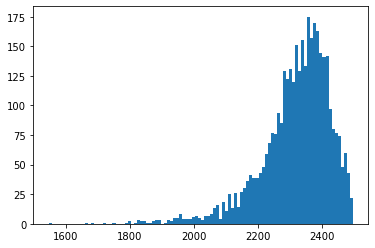

In [80]:
# distribution of zero features in the data, to set the threshold of outliers

plt.hist((fdata_small == 0).sum(axis=1), bins=100)
plt.show()

In [81]:
# remove samples which don't have at least 10 non-zero features

indexes = (fdata_small == 0).sum(axis=1)<2490   # At least 10 nonzero values 
fdata_new = fdata_small.loc[indexes]
fdata_new.shape # new data shape
y_train_new = y_train.loc[indexes]  # new training label

In [82]:
print('New shape: {}'.format(fdata_new.shape))

New shape: (3659, 2500)


## Rescaling

#### Let's rescale the data between the range [0,1]

In [83]:
# rescale the data

scaler = MinMaxScaler(feature_range=(0,1))
fdata_scaled = pd.DataFrame(scaler.fit_transform(fdata_new))
fdata_scaled.columns = fdata_new.columns

scaler_test = MinMaxScaler(feature_range=(0,1))
fdata_scaled_test = pd.DataFrame(scaler.fit_transform(fdata_test_small))
fdata_scaled_test.columns = fdata_test_small.columns

In [84]:
print('The final data look like this:')
fdata_scaled.head()

The final data look like this:


,<UNK>,us,data,privacy,company,policy,team,use,technology,business,...,finish,resident,query,florida,ai_encoding,machine_encoding,artificial_encoding,deep_encoding,ml_encoding,all_encoding
0,0.026523,0.099099,0.015267,0.121212,0.016760,0.035794,0.051724,0.009615,0.007299,0.006944,...,0.0,0.0,0.0,0.083333,1.0,0.0,0.0,0.0,0.0,1.0
1,0.018794,0.045045,0.022901,0.030303,0.005587,0.026846,0.068966,0.105769,0.003650,0.027778,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.002273,0.027027,0.015267,0.045455,0.000000,0.006711,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.028797,0.153153,0.156489,0.045455,0.025140,0.000000,0.310345,0.105769,0.029197,0.027778,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.164595,0.027027,0.000000,0.015152,0.002793,0.002237,0.000000,0.000000,0.000000,0.076389,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


## Model

In [86]:
# create the model

model = RandomForestClassifier(n_estimators=1000, criterion='entropy') # hyperparameters optimized through gridsearch

# cv_accuracy = cross_val_score(model, fdata_small, y_train, cv=4)  # compute the cross validation score
# print('Cross-validation accuracy: {}'.format(cv_accuracy))
# print('Mean and std: {}, {}'.format(cv_accuracy.mean(), cv_accuracy.std()))

model.fit(fdata_new, y_train_new)  # fit the model
predictions = model.predict(fdata_test_small)   # compute the predictions
score = model.score(fdata_test_small, y_test)   # compute the score on the test set

print('Test accuracy: {}'.format(score))

Test accuracy: 0.8676470588235294


## Confusion Matrix 

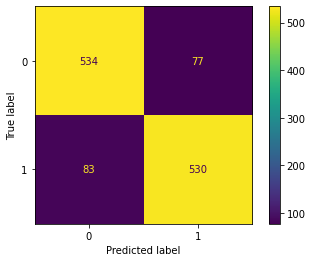

In [75]:
# inspect the confusion matrix to see the false negatives/ false positives rate

matrix = confusion_matrix(y_test, predictions)
display_matrix = ConfusionMatrixDisplay(matrix).plot()

## GridSearch Hyperparameters Optimization

In [74]:
# hyperparameter optimization

parameters = {'n_estimators':[100, 500, 1000], 'criterion':['gini', 'entropy'], 'max_depth':[100, 10000]} # parameter grid
clf = GridSearchCV(model, parameters)
clf.fit(fdata_small, y_train)

print('Best score: {}'.format(clf.best_score_))
print('Best parameters: {}'.format(clf.best_params_))

Best score: 0.8596730245231609
Best parameters: {'criterion': 'gini', 'max_depth': 10000, 'n_estimators': 1000}
